# Feature finding in 3D confocal images

Confocal microscopy is a techique that is able to make image slices of your sample. New developments (spinning disk scanning, resonant mirrors) have made this technique sufficiently fast for 3D tracking. Commonly, the sample is mounted on a piezo stage that is able to quickly scan the sample in Z direction. In this way, sequences of Z pictures can be made. By repeating this, the sample can be followed real-time in 3D.

Because of the different techniques used for XY and Z resolution, pixel sizes in these directions are mostly not equal. It is easy to extend the method of Crocker & Grier to 3 dimensions with different feature sizes. Trackpy can do this from version v0.3; the only thing you need to do is load your images as 3 dimensional numpy arrays and supply a tuple value for diameter, describing feature size in each dimension.

First, we initalize IPython and load the required packages. PIMS and Trackpy v0.3 are required.

## Modification History:

v9: edit as necessary for 2017-4-11 data and save path modification. 6-13-17

## Setup IPython, pims, trackpy

In [23]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('figure',  figsize=(10, 6))
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp
import os

In [24]:
import annotate3d_custom

## Import 3D images

We make use of `ImageSequenceND`. This reader class searches for files matching a certain search string. The filename should contain indentifiers for each axis (dimension). For example `"demo_t001_z001.png"` contains identifiers `t` and `z`. We set the returned image axes to `zyx` and the iterating axis to `t`. In this way we get 3D images indexed by `t`.

For this tutorial, the images are inside a zipfile. You can extract the images from the specified archive to check them out.

In [25]:
path = r'C:\Eric\Xerox Data\test displacements\8-29-17 1.0 p300\u0_bpass3D\*.tif';
frames = pims.ImageSequenceND(path, axes_identifiers = ['z'])
# frames.bundle_axes = ['z', 'y', 'x']    # Not actually necessary. Already bundles z,y,x
frames

<ImageSequenceND>
Source: C:\Eric\Xerox Data\test displacements\8-29-17 1.0 p300\u0_bpass3D\*.tif
Axes: 3
Axis 'y' size: 512
Axis 'x' size: 512
Axis 'z' size: 50
Pixel Datatype: uint8

The time-index of the first frame is always 0, regardless of the index in the filename. We can use `pims` 3d scrollable stack feature to display a 3D image. Use the scroll wheel to scroll through the focal planes.

This feature will not work online, download the example and run it yourself to checkout the scrollable stack feature.

In [26]:
#frames[0]

## Feature finding

Try adding a modified annotate3d function to print all of the located particles nearby in the z dimension.

In [27]:
try:
    from pims import plot_to_frame, plots_to_frame, normalize
except ImportError:
    plot_to_frame = None
    plots_to_frame = None
    normalize = None

Include modified functions for annotate3d to display the circles for more zframes and save the images.

In [28]:
def annotate3d_zrange(centroids, image, **kwargs):
    """Annotates a 3D image and returns a scrollable stack for display in
    IPython.
    
    Parameters
    ----------
    centroids : DataFrame including columns x and y
    image : image array (or string path to image file)
    circle_size : Deprecated.
        This will be removed in a future version of trackpy.
        Use `plot_style={'markersize': ...}` instead.
    color : single matplotlib color or a list of multiple colors
        default None
    invert : If you give a filepath as the image, specify whether to invert
        black and white. Default True.
    ax : matplotlib axes object, defaults to current axes
    split_category : string, parameter to use to split the data into sections
        default None
    split_thresh : single value or list of ints or floats to split
        particles into sections for plotting in multiple colors.
        List items should be ordered by increasing value.
        default None
    imshow_style : dictionary of keyword arguments passed through to
        the `Axes.imshow(...)` command the displays the image
    plot_style : dictionary of keyword arguments passed through to
        the `Axes.plot(...)` command that marks the features
    Returns
    -------
    pims.Frame object containing a three-dimensional RGBA image
    See Also
    --------
    annotate : annotation of 2D images
    """
    import trackpy as tp
    
    if plots_to_frame is None:
        raise ImportError('annotate3d requires pims 0.3 or later, please '
                          'update pims')

    import matplotlib as mpl
    import matplotlib.pyplot as plt

    if image.ndim != 3 and not (image.ndim == 4 and image.shape[-1] in (3, 4)):
        raise ValueError("image has incorrect dimensions. Please input a 3D "
                         "grayscale or RGB(A) image. For 2D image annotation, "
                         "use annotate. Multichannel images can be "
                         "converted to RGB using pims.display.to_rgb.")

    # We want to normalize on the full image and stop imshow from normalizing.
    normalized = (normalize(image) * 255).astype(np.uint8)
    imshow_style = dict(vmin=0, vmax=255)
    if '_imshow_style' in kwargs:
        kwargs['imshow_style'].update(imshow_style)
    else:
        kwargs['imshow_style'] = imshow_style

    max_open_warning = mpl.rcParams['figure.max_open_warning']
    was_interactive = plt.isinteractive()
    try:
        # Suppress warning when many figures are opened
        mpl.rc('figure', max_open_warning=0)
        # Turn off interactive mode (else the closed plots leave emtpy space)
        plt.ioff()

        figures = [None] * len(normalized)
        for i, imageZ in enumerate(normalized):
            fig = plt.figure()
            kwargs['ax'] = fig.gca()
            
            # Can use centroidsZ to specify how close particles need to be in
            # the z-direction to be circled. Default uses zhold = 0
            zhold = 5;
            centroidsZ = centroids[(centroids['z'] > i - zhold - 0.5) &
                                   (centroids['z'] < i + zhold + 0.5)]
            tp.annotate(centroidsZ, imageZ, **kwargs)
            
#             # Use regular centriods to put all circles on every image
#             tp.annotate(centroids, imageZ, **kwargs)
            
            figures[i] = fig

        result = plots_to_frame(figures, width=512, close_fig=True,
                                bbox_inches='tight')
    finally:
        # put matplotlib back in original state
        if was_interactive:
            plt.ion()
        mpl.rc('figure', max_open_warning=max_open_warning)

    return result

In [29]:
def annotate3d_zrange_saveStack(centroids, image, path, **kwargs):
    """Annotates a 3D image and returns a scrollable stack for display in
    IPython.
    
    Parameters
    ----------
    centroids : DataFrame including columns x and y
    image : image array (or string path to image file)
    circle_size : Deprecated.
        This will be removed in a future version of trackpy.
        Use `plot_style={'markersize': ...}` instead.
    color : single matplotlib color or a list of multiple colors
        default None
    invert : If you give a filepath as the image, specify whether to invert
        black and white. Default True.
    ax : matplotlib axes object, defaults to current axes
    split_category : string, parameter to use to split the data into sections
        default None
    split_thresh : single value or list of ints or floats to split
        particles into sections for plotting in multiple colors.
        List items should be ordered by increasing value.
        default None
    imshow_style : dictionary of keyword arguments passed through to
        the `Axes.imshow(...)` command the displays the image
    plot_style : dictionary of keyword arguments passed through to
        the `Axes.plot(...)` command that marks the features
    Returns
    -------
    pims.Frame object containing a three-dimensional RGBA image
    See Also
    --------
    annotate : annotation of 2D images
    """
    import trackpy as tp
    
    if plots_to_frame is None:
        raise ImportError('annotate3d requires pims 0.3 or later, please '
                          'update pims')

    import matplotlib as mpl
    import matplotlib.pyplot as plt

    if image.ndim != 3 and not (image.ndim == 4 and image.shape[-1] in (3, 4)):
        raise ValueError("image has incorrect dimensions. Please input a 3D "
                         "grayscale or RGB(A) image. For 2D image annotation, "
                         "use annotate. Multichannel images can be "
                         "converted to RGB using pims.display.to_rgb.")

    # We want to normalize on the full image and stop imshow from normalizing.
    normalized = (normalize(image) * 255).astype(np.uint8)
    imshow_style = dict(vmin=0, vmax=255)
    if '_imshow_style' in kwargs:
        kwargs['imshow_style'].update(imshow_style)
    else:
        kwargs['imshow_style'] = imshow_style

    max_open_warning = mpl.rcParams['figure.max_open_warning']
    was_interactive = plt.isinteractive()
    try:
        # Suppress warning when many figures are opened
        mpl.rc('figure', max_open_warning=0)
        # Turn off interactive mode (else the closed plots leave emtpy space)
        plt.ioff()

        figures = [None] * len(normalized)
        for i, imageZ in enumerate(normalized):
            fig = plt.figure()
            kwargs['ax'] = fig.gca()
            
            # Can use centroidsZ to specify how close particles need to be in
            # the z-direction to be circled. Default uses zhold = 0
            zhold = 5;
            centroidsZ = centroids[(centroids['z'] > i - zhold - 0.5) &
                                   (centroids['z'] < i + zhold + 0.5)]
            tp.annotate(centroidsZ, imageZ, **kwargs)
            
#             # Use regular centriods to put all circles on every image
#             tp.annotate(centroids, imageZ, **kwargs)
            
            figures[i] = fig
            
            # Make new directory and save path
            newpath = newpath = path[:-5]+ r'annotated'
            if not os.path.exists(newpath):
                os.makedirs(newpath)
            savepath = path[:-5]+ r'annotated\z' + str(i) + '.tif';
            fig.savefig(savepath,bbox_inches='tight')
        result = plots_to_frame(figures, width=512, close_fig=True,
                                bbox_inches='tight')
    finally:
        # put matplotlib back in original state
        if was_interactive:
            plt.ion()
        mpl.rc('figure', max_open_warning=max_open_warning)

    return result

Now we can use `trackpy.locate` to generate a table (a pandas `DataFrame`) of the feature coordinates. `locate` only requires a feature diameter. This needs to be an odd integer and can be specified for each dimension seperately. The order of dimensions is the same as the order of the image array, typically (z, y, x).

In [30]:
#tp.locate?

In [31]:
features = tp.locate(frames[0], diameter=(15, 15, 15), invert = False, separation = (7,7,7), preprocess = False, minmass = 60000) 
# preprocess = False disables bandpass filtering by trackpy (do my own first instead)
features.head()  # displays first 5 rows

x          y         z      mass      size  ecc  signal  raw_mass  \
0   85.321040  28.590975  7.220199   78956.0  4.998694  NaN    96.0   78956.0   
1  189.450218  31.797360  6.572312  106835.0  4.959144  NaN   127.0  106835.0   
2  482.024064  35.170432  8.259679  113987.0  5.022196  NaN   127.0  113987.0   
3  327.083263  55.933142  7.017529   88995.0  4.992681  NaN   129.0   88995.0   
4  469.722539  58.082315  7.125920  118885.0  5.077337  NaN   128.0  118885.0   

   ep  frame  
0 NaN      0  
1 NaN      0  
2 NaN      0  
3 NaN      0  
4 NaN      0

Because we specified different diameters for each dimension, trackpy we return `size` and `ep` (static error) for each dimension seperately. We can plot the feature locations on top of the original picture. You can see that there are no features found at the edges. This is because these particles partly fall out of the measurement box.

In [32]:
# Save the data to csv file
features.to_csv(path[:-5] + 'features.csv');

In [33]:
# annotate3d_zrange(features, frames[0])
# # seems to be blurring together particles in the z-axis (Counting two as the same if they are close to being on top
# # of each other).?

Frame([[[[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        ..., 
        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]]],


       [[[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        ..., 
        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]]],


       [[[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        ..., 
        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]]],


       ..., 
       [[[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 
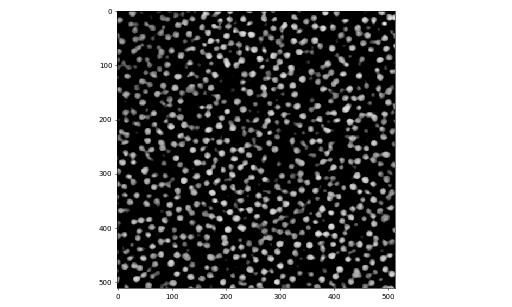
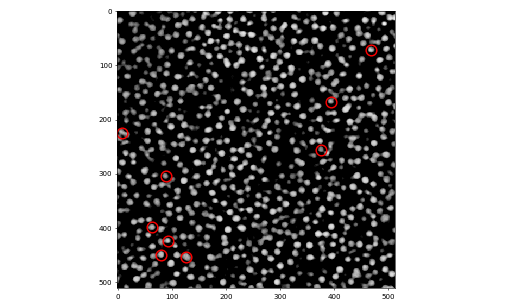
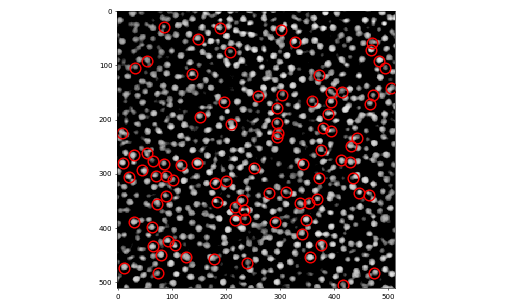
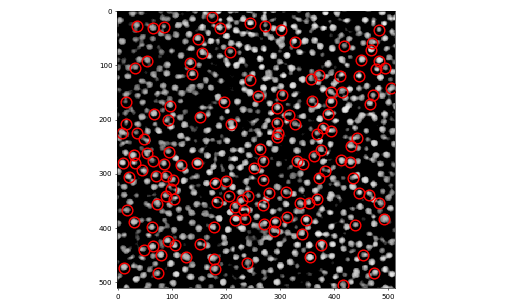
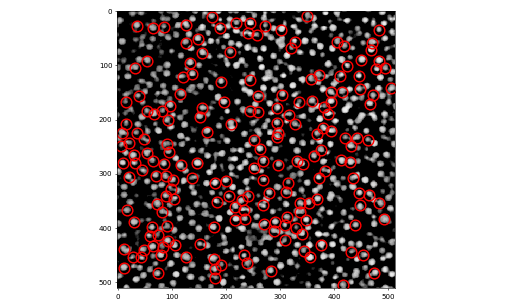
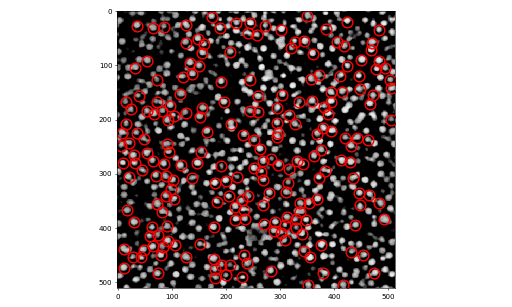
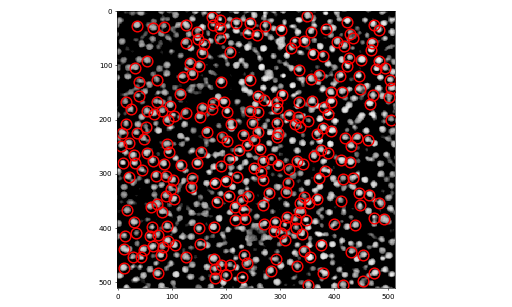
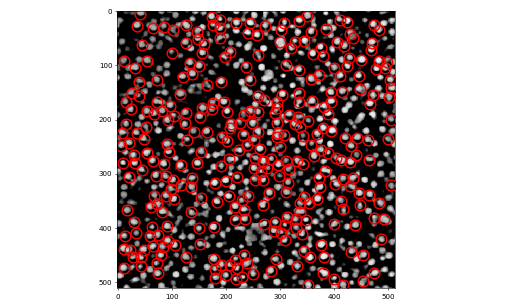
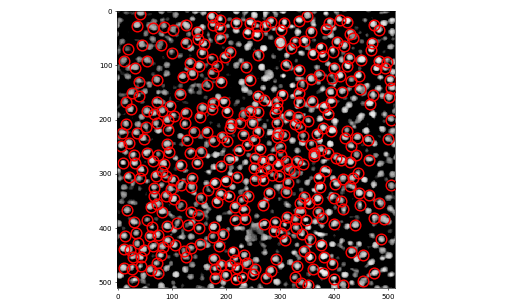
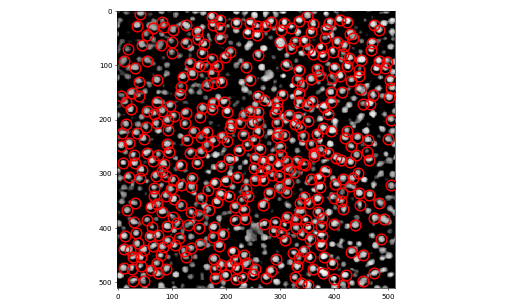
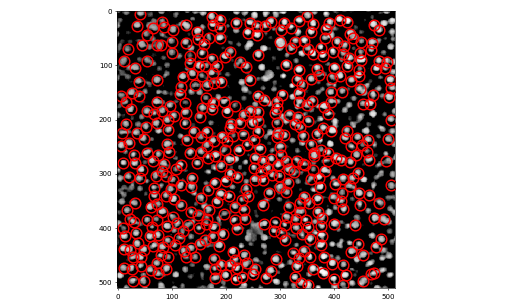
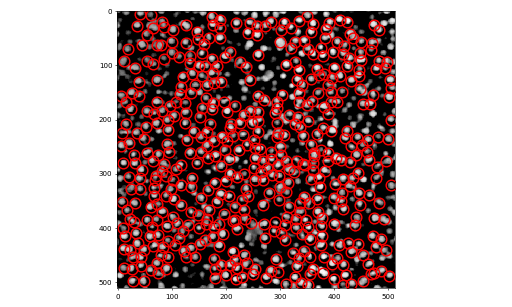
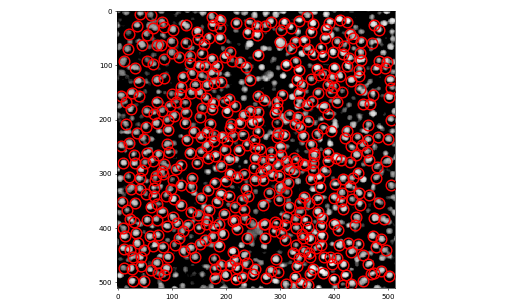
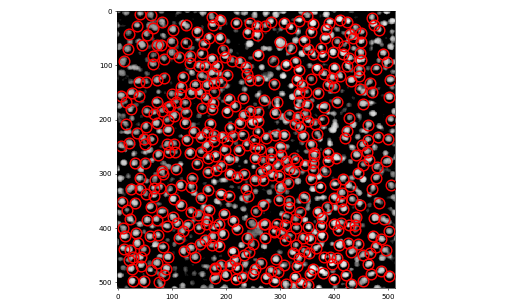
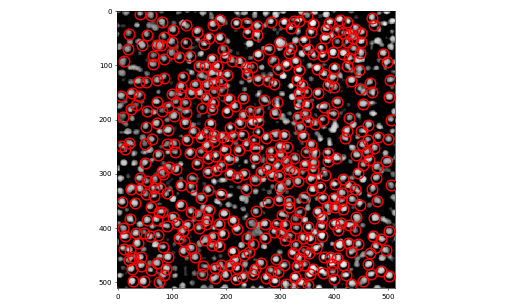
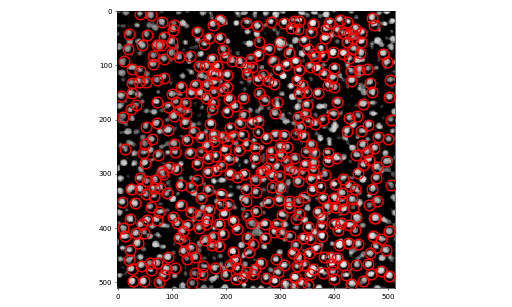
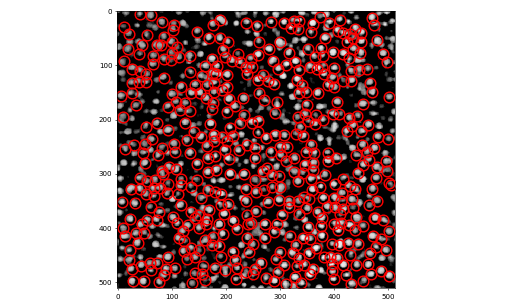
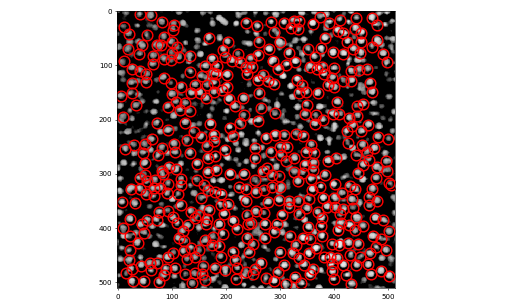
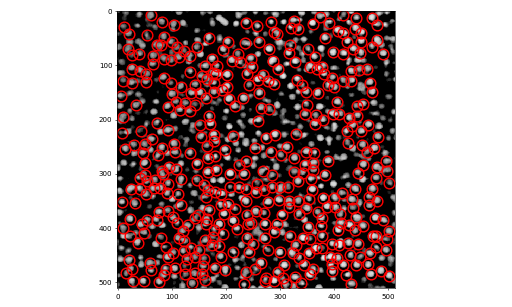
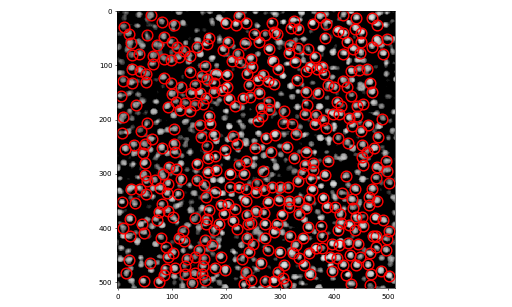
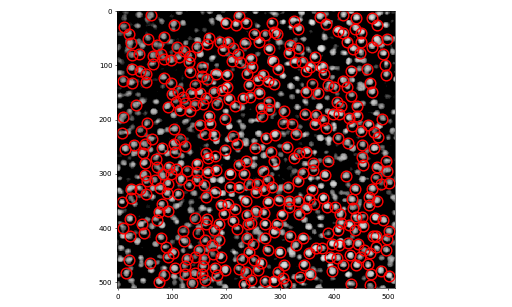
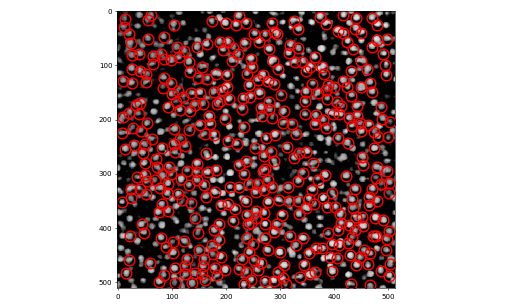
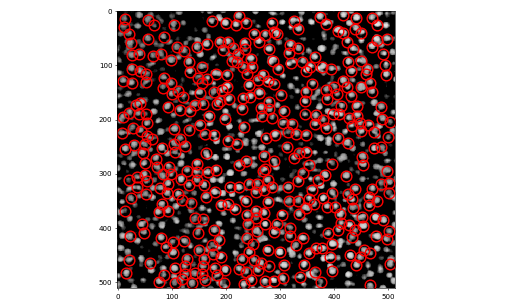
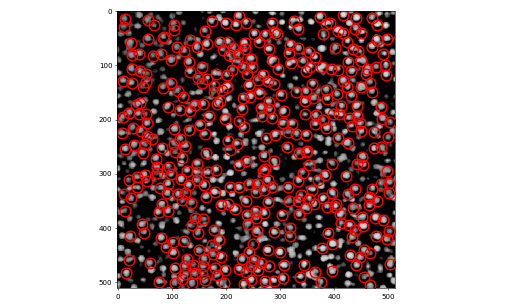
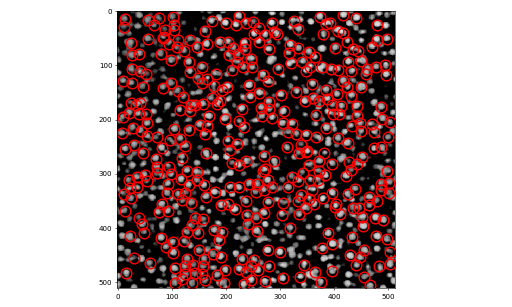
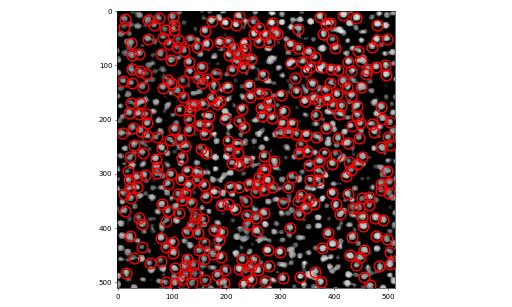
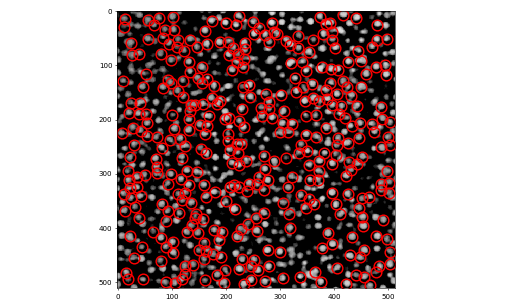
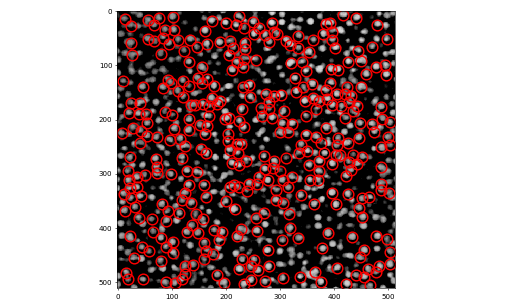
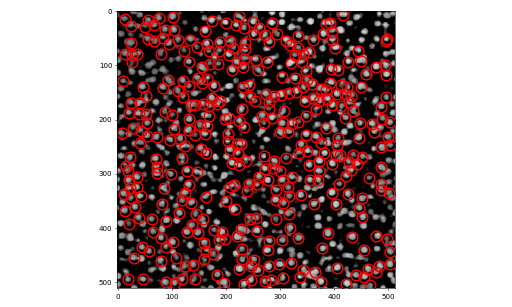
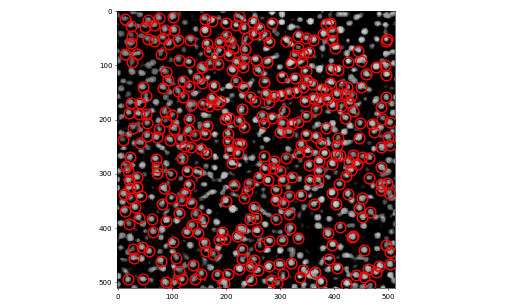
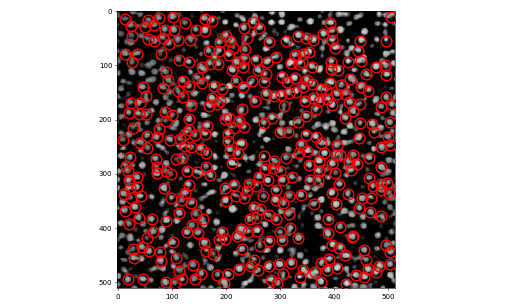
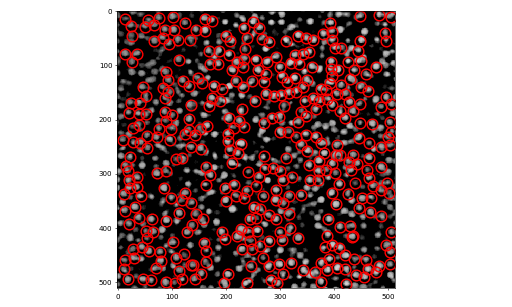
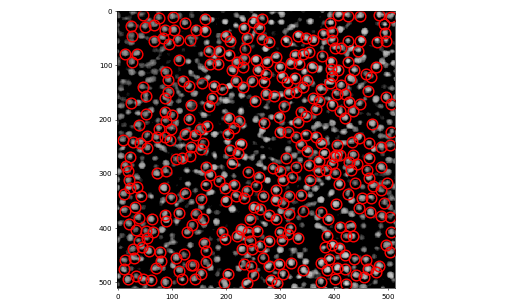
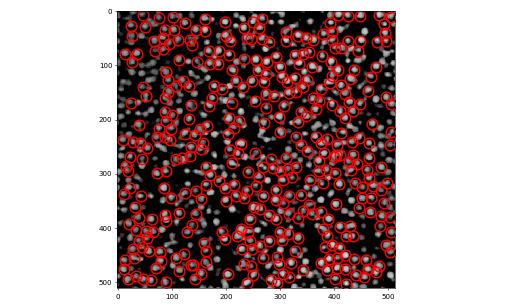
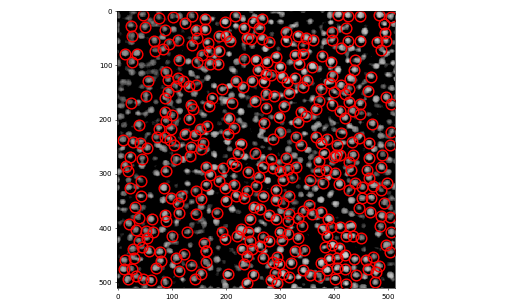
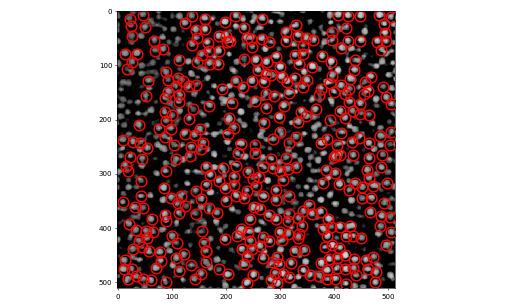
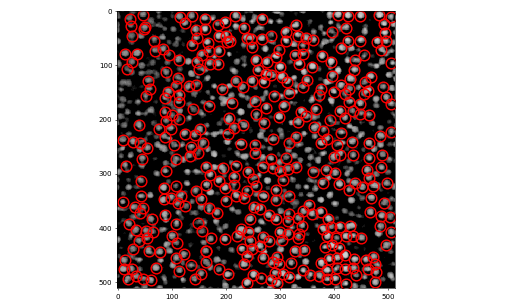
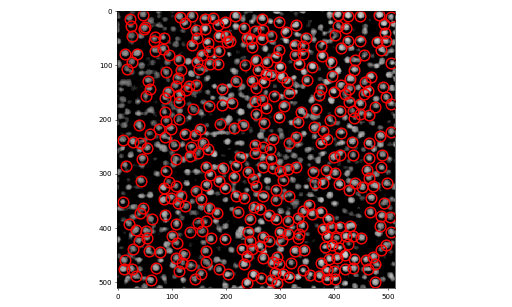
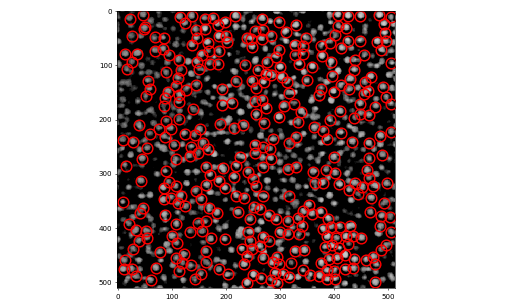
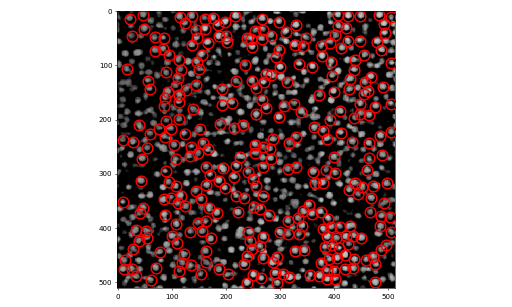
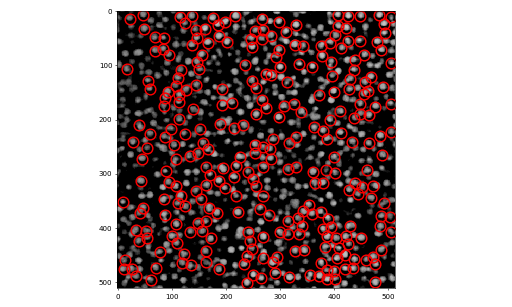
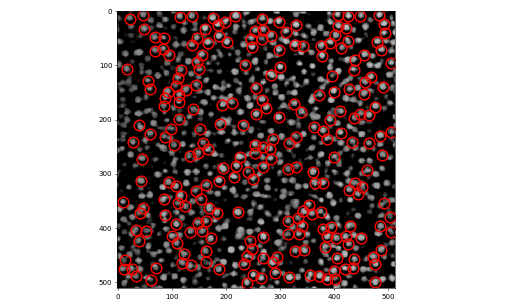
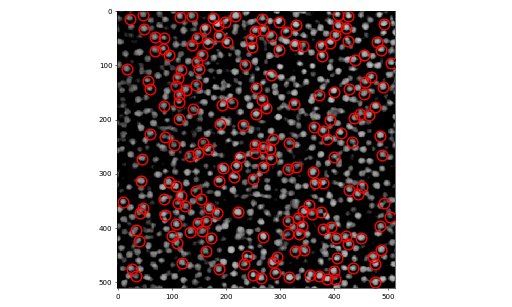
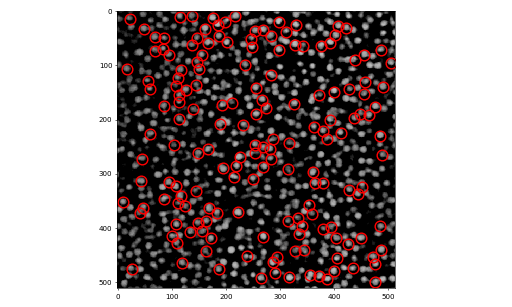
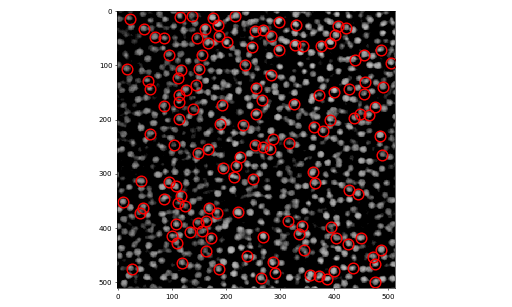
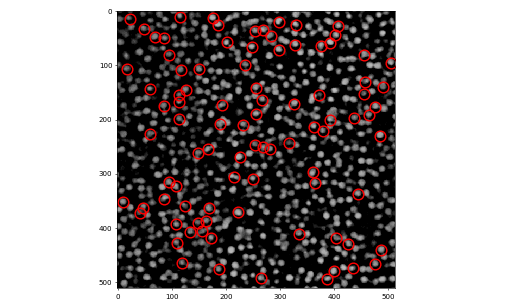
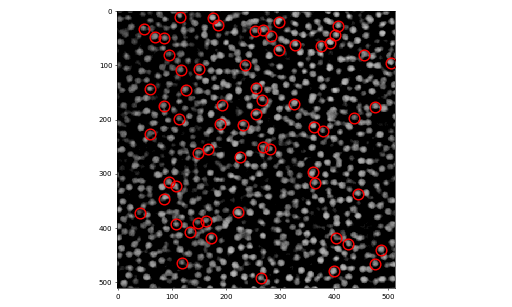
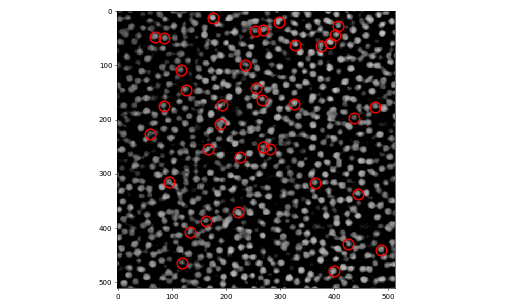
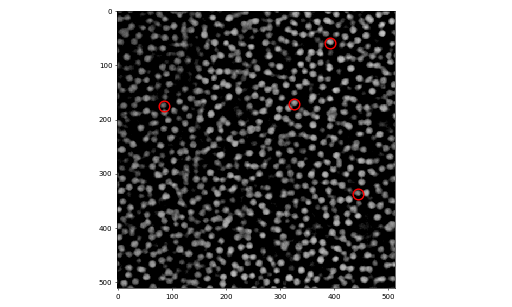
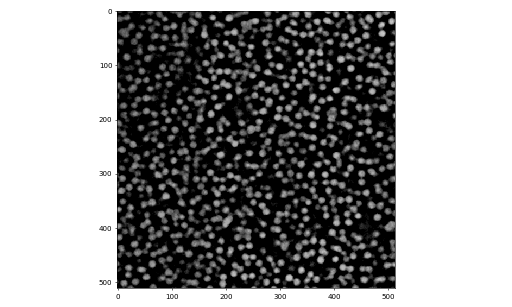

In [34]:
annotate3d_zrange_saveStack(features, frames[0], path)
# seems to be blurring together particles in the z-axis (Counting two as the same if they are close to being on top
# of each other).

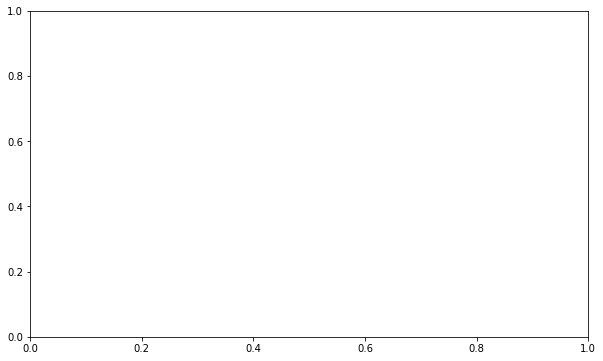

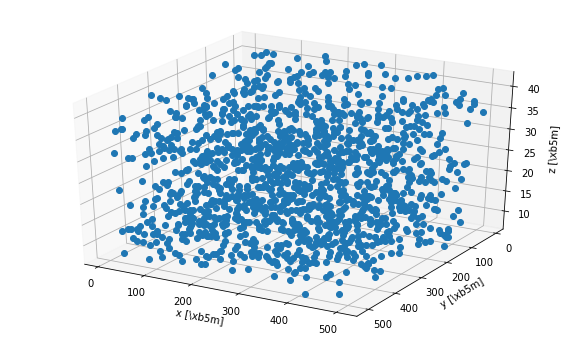

In [35]:
tp.scatter3d(features, frames[0])

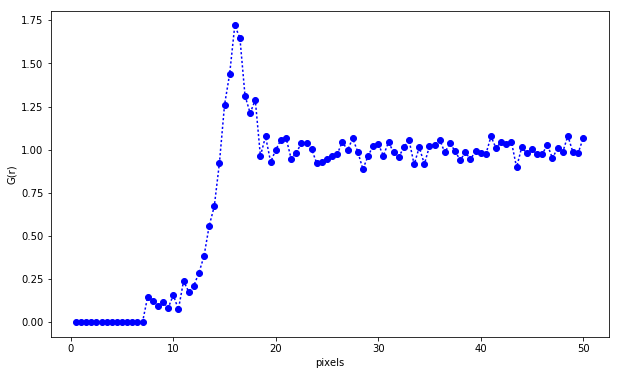

In [36]:
[edges, g_r] = tp.pair_correlation_3d(features, 50)
fig, ax = plt.subplots()
ax.plot(edges[1:], g_r, 'b:o');
ax.set(ylabel='G(r)',
       xlabel='pixels');
# fig.savefig(r'C:\Users\Eric\Documents\Xerox\Monthly Meetings\images\ts5_bpass_gr.tif',bbox_inches='tight',frameon = False, dpi = 800);

In [41]:
print(np.max(g_r))
print(np.argmax(g_r))
print(edges[np.argmax(g_r)+1])

print('Features found: {0}'.format(len(features)))

print(edges[np.argmax(g_r)+6])

1.72033826483
31
16.0
Features found: 1387
18.5


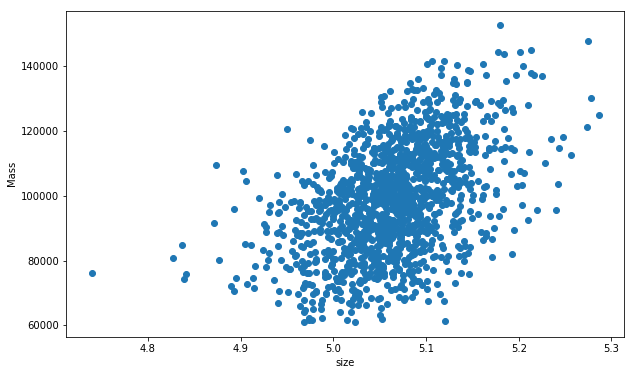

In [38]:
fig, ax = plt.subplots()
ax.plot(features['size'], features['mass'],'o');
ax.set(ylabel='Mass',
       xlabel='size');
# fig.savefig(r'C:\Users\Eric\Documents\Xerox\Monthly Meetings\images\mass_vs_sizx.png',bbox_inches='tight',frameon = False, dpi = 800);

In [39]:
rg = np.mean(features['size']); # radius of gyration
mean_radius = np.sqrt(5/3*rg**2);
print('mean rg', mean_radius)

max_rg = np.max(features['size']);
print('max rg', max_rg)

('mean rg', 5.0637934211068236)
('max rg', 5.2866605790621115)


To see wether the features are biased by the pixelation, we can take histograms of the decimal part of the coordinates. As particles don't know about the pixel grid, these distributions should be flat.

Features found: 1387


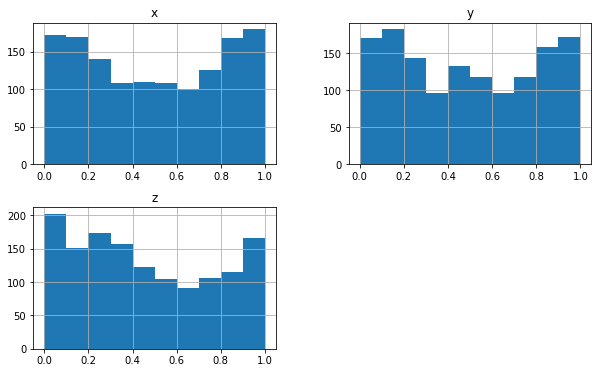

In [40]:
tp.subpx_bias(features)
print('Features found: {0}'.format(len(features)))

In [34]:
# features3 = tp.locate(frames[0], diameter=(7, 11, 11), separation=(3, 11, 11))
# print('Features found: {0}'.format(len(features3)))
# tp.annotate3d(features3, frames[0])